# Laplacian Associative Memory (LAM) - DEV 18a

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- End-2-End Testing

In [15]:
from nn import LAM
import libtools

In [16]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
# np.random.seed(123)

---

#### LOAD DATA

In [18]:
src = np.load('../data/mat/SOM_orient_v1.npy')

print('Map:', src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

Map: (201, 201)
Theta θ | min: 0.0 max: 6.2832


In [19]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
img /= np.max(img) # Normalize

print('Image:', img.shape)
print('min:', round(img.min(),4), 'max:', round(img.max(),4))

Image: (201, 201)
min: 0.0496 max: 1.0


---

### GABOR

In [20]:
step = 20
f_size = 5

pad = int(step/2)
pad_im = np.pad(img, pad, mode='constant', constant_values=0)
features = np.zeros_like(pad_im)

for i in range(src.shape[0]):
    for j in range(src.shape[1]):
        arctan = src[i][j] - np.pi # Arc tangent | -π and π
        deg = np.rad2deg(arctan*0.5) # *0.5 to keep range between -90 and 90
        kernel = libtools.gabor_filter(2, 1, deg, samples=step, min=-f_size, max=f_size) # Orientation
        patch = pad_im[i:i+step, j:j+step]
        features[int(i+pad),int(j+pad)] = np.sum(patch * kernel) # Firing Rate / Response
        
features = features[pad:pad+src.shape[0],pad:pad+src.shape[1]]
features[features<=0] = 0 # Rectify???

Text(0.5, 1.0, 'Inverse Tangent Activation Response')

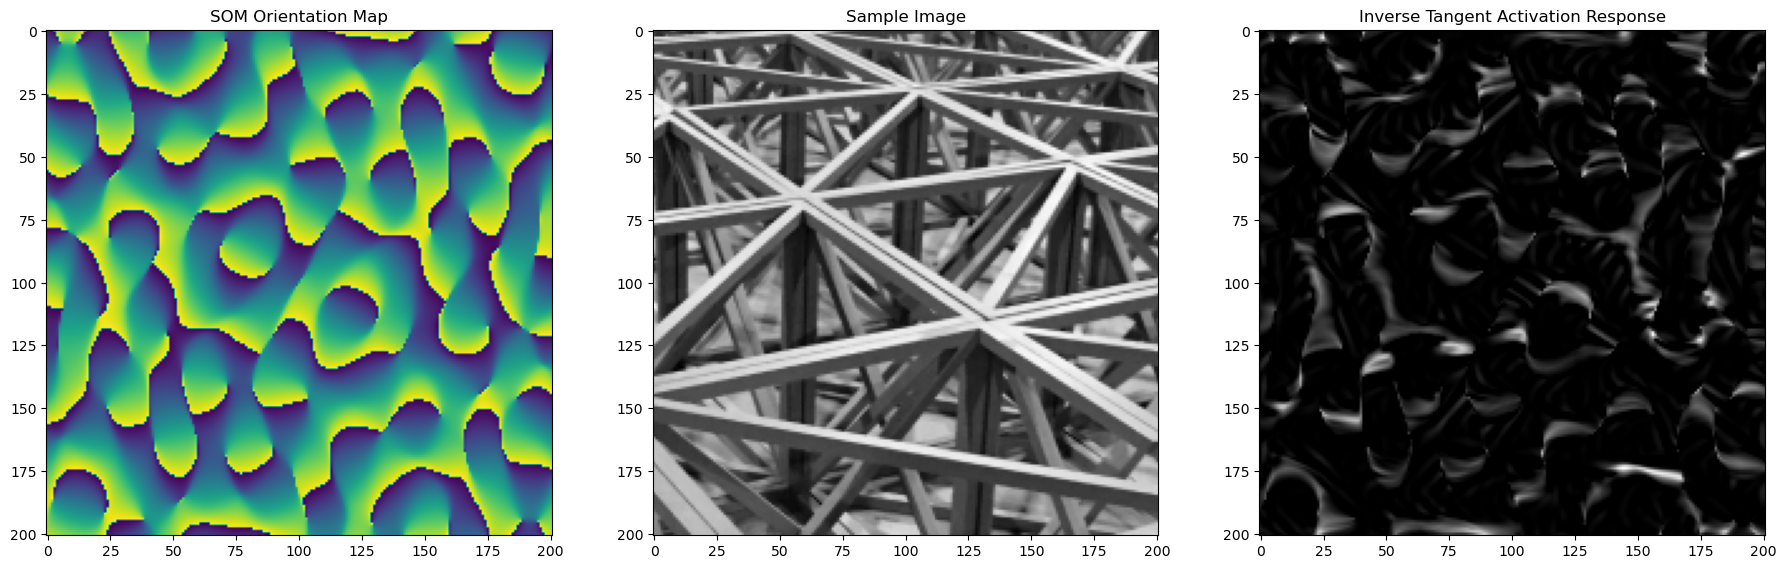

In [21]:
plt.figure(figsize=(30,10))
plt.subplot(1,4,1)
plt.imshow(src)
plt.title('SOM Orientation Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Sample Image')

plt.subplot(1,4,3)
plt.imshow(features, 'gray')
plt.title('Inverse Tangent Activation Response')

---

### HYPER-PARAMETERS

In [22]:
# Optimize / resize data
src = libtools.downsample(src, 4)
features = libtools.downsample(features, 4)

N = 8192                            # Neurons | Default: 30000
prob = 0.1                          # Sparsity
eta = 0.01                          # Epsilon / Learning rate
simlen = 3000                       # Steps
gamma = 0.6                         # Inhibition ratio
norm_mode = 'asym'                  # Asymmetric Normalisation
alpha = -0.9                        # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]     # N Nodes

sigmaX = 0.1                        # Spatial Gaussian Scale
sigmaA = 0.1                        # Angular Component Scale

# Init condition (Center cell)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


---

### COMPUTE

In [23]:
W = libtools.construct_SOAM(src, sigmaX, sigmaA)

In [24]:
graph = LAM(N, P, prob, W, gamma, "asym")

In [25]:
# Build initial state
M = np.size(graph.xi, axis=1) # Nodes
Ix = np.zeros_like(graph.xi) # Malloc

for node in range(M):
    k = features.flatten()[node] # Gabor response
    state = graph.xi[:, node].copy() # State of each node
    state = (graph.xi[:, node] * 2) - 1 # Map between -1 and 1
    state *= k # Multiply against response
    Ix[:,node] = state

Inorm = np.sum(Ix, axis=1) * 1/M

In [26]:
# Step Function 1
diff = abs(Inorm.min() - Inorm.max()) 
threshold = (diff * graph.prob) + Inorm.min()
# I = np.where(Inorm < threshold, 1, 0).astype('float')

print('Min:', round(Inorm.min(),4))
print('Max:', round(Inorm.max(),4))
print('Diff:', round(diff,4))
print('Threshold:', round(threshold,4))

Min: -0.1001
Max: -0.0766
Diff: 0.0235
Threshold: -0.0978


Text(0.5, 1.0, 'Step Function')

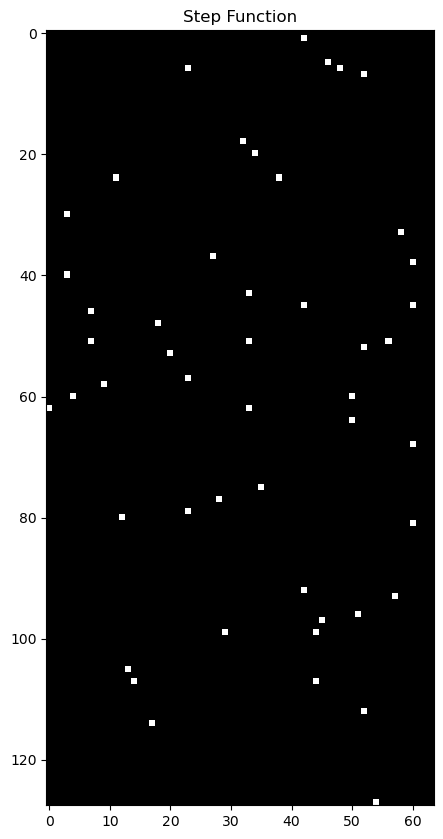

In [27]:
# # Step Function 2
I = Inorm + abs(Inorm.min())
I *= 1.0/I.max()
I = np.where(I < graph.prob, 1, 0).astype('float')

plt.figure(figsize=(5,15))
plt.imshow(I.reshape([128, 64]), 'gray')
plt.title('Step Function')

In [28]:
### SIMULATION
m_log, _ = graph.simulate_single(alpha, eta, simlen, I.copy())

100%|██████████| 3000/3000 [01:36<00:00, 31.18it/s]


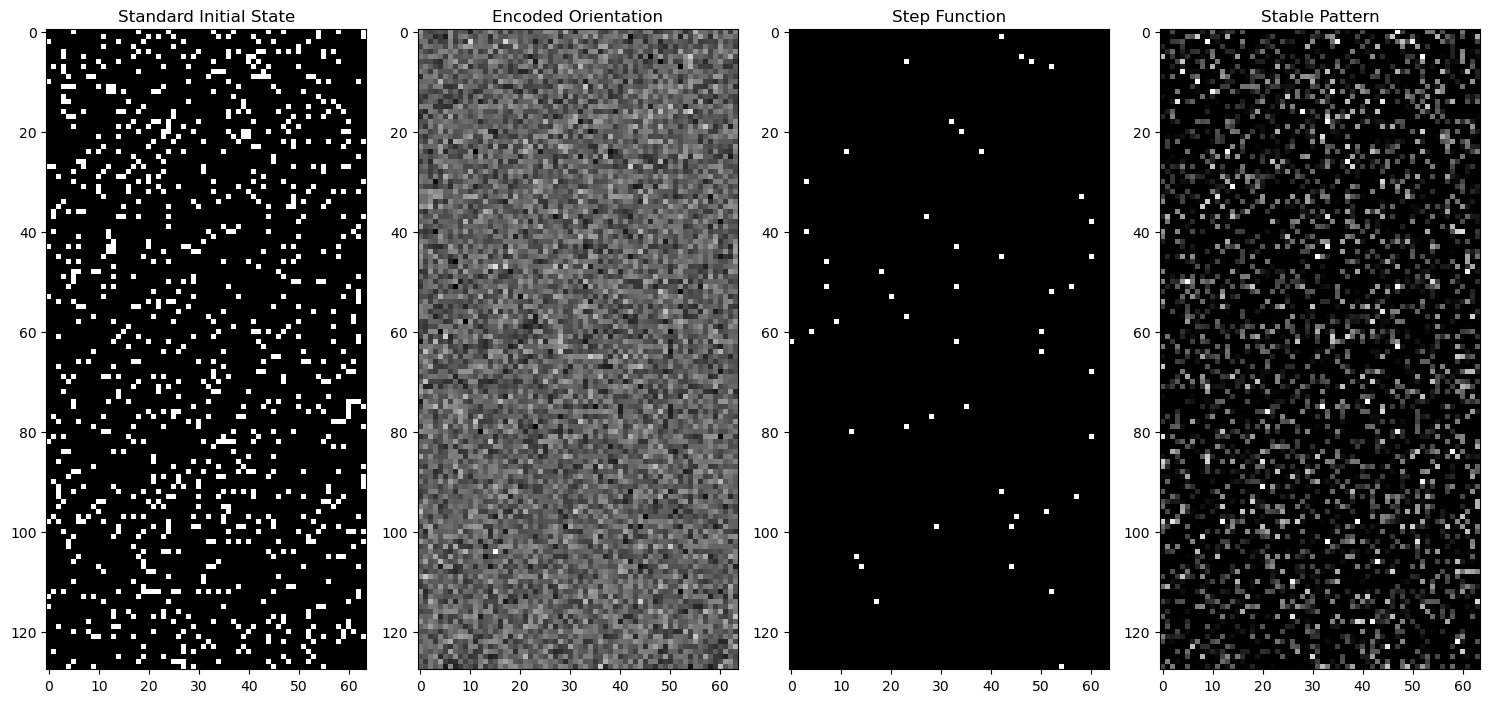

In [29]:
dims = [128, 64]
grade = 'gray'

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(graph.xi[:, start_node].reshape(dims), grade)
plt.title('Standard Initial State')

plt.subplot(1,4,2)
plt.imshow(Inorm.reshape(dims), grade)
plt.title('Encoded Orientation')

plt.subplot(1,4,3)
plt.imshow(I.reshape(dims), grade)
plt.title('Step Function')

plt.subplot(1,4,4)
plt.imshow(graph.x.reshape(dims), grade)
plt.title('Stable Pattern')
plt.tight_layout()

---

### PLOT

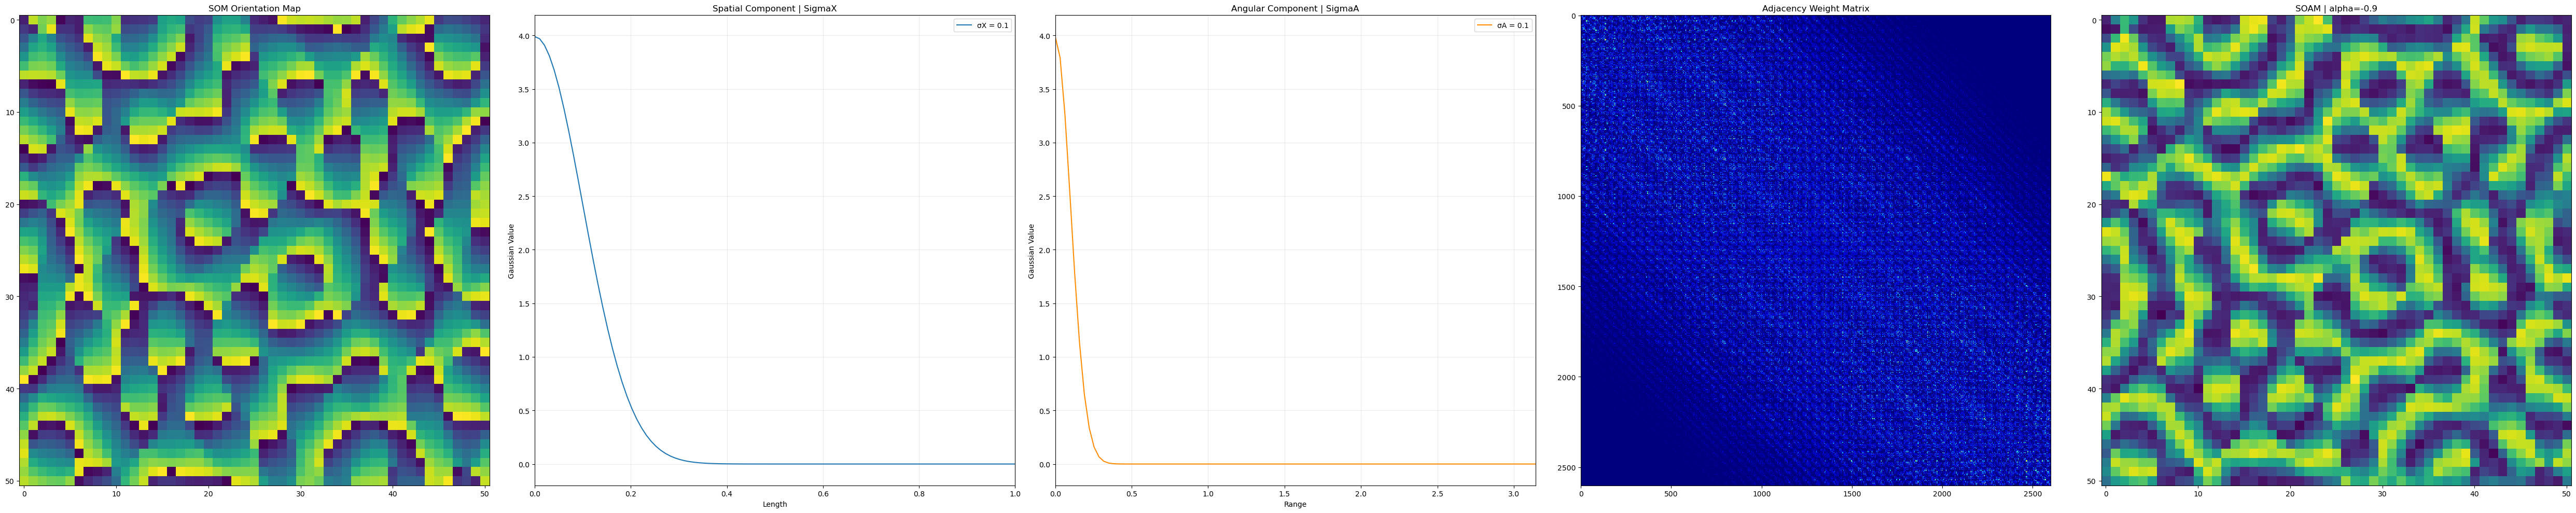

In [30]:
plt.figure(figsize=(50,10))
plt.subplot(1, 5, 1)
plt.imshow(src)
plt.title('SOM Orientation Map')

dist_s = np.linspace(0, 1, 100)
dist_a = np.linspace(0, np.pi, 100)

plt.subplot(1, 5, 2)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Length'), plt.ylabel('Gaussian Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 5, 3)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range'), plt.ylabel('Gaussian Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 5, 4)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(1, 5, 5)
plt.imshow(m_log[-1,:].reshape(src.shape))
plt.title('SOAM | alpha=' + str(alpha))
plt.tight_layout()